In [1]:
from manifold_learning import IMD
import numpy as np
from FastCCM import CCM, CCM_utils
from manifold_learning.utils import utils
from manifold_learning.data.data_loader import load_csv_dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from manifold_learning import imd_nd_smap
import importlib
import scipy.cluster.hierarchy as sch
import seaborn as sns
importlib.reload(imd_nd_smap)
importlib.reload(CCM)

<module 'FastCCM.CCM' from '/home/iaroslav/Documents/Python projects/FastCCM/src/FastCCM/CCM.py'>

In [2]:

from matplotlib.colors import LinearSegmentedColormap

def plot_pairwise_arrows_with_direction_gradient(ax,pairwise_matrix, strength_matrix, points, start_color='blue', end_color='red', steps=100):
    """
    Plots arrows between points based on a pairwise matrix, with arrow color as a gradient
    from start_color to end_color and width determined by connection strength. Points are plotted in black.

    Parameters:
    - pairwise_matrix (ndarray): Boolean matrix indicating direction of connections (True/False).
    - strength_matrix (ndarray): Numeric matrix indicating strength of connections.
    - points (ndarray): Coordinates of points as an (N, 2) array.
    - start_color (str): Color of the arrow's start.
    - end_color (str): Color of the arrow's end.
    - steps (int): Number of gradient segments.

    Returns:
    - None
    """

    # Normalize strength matrix for line width scaling
    min_strength = np.min(strength_matrix[strength_matrix > 0])
    max_strength = np.max(strength_matrix)
    normalize_strength = lambda s: (s - min_strength) / (max_strength - min_strength) + 0.1

    # Plot the points in black
    ax.scatter(points[:, 0], points[:, 1], color='black', s=50, zorder=5)

    # Plot the arrows
    for i in range(pairwise_matrix.shape[0]):
        for j in range(pairwise_matrix.shape[1]):
            if pairwise_matrix[i, j]:  # Check if there's a connection
                start = points[i]
                end = points[j]
                strength = strength_matrix[i, j]
                width = normalize_strength(strength)  # Scale the width based on strength
                gradient_arrow(ax, start, end, start_color, end_color, width, steps)

    # Customize plot
    #ax.set_xlim(points[:, 0].min() - 0.5, points[:, 0].max() + 0.5)
    #ax.set_ylim(points[:, 1].min() - 0.5, points[:, 1].max() + 0.5)
    #ax.set_aspect('equal', adjustable='datalim')
    #ax.set_title('Pairwise Connections with Gradient-Colored Arrows and Points')
    plt.grid()
    plt.show()

def gradient_arrow(ax, start, end, start_color, end_color, width, steps):
    """
    Draws a single arrow with a gradient color and adjustable width.

    Parameters:
    - ax: Matplotlib axis object.
    - start (tuple): Starting point (x, y).
    - end (tuple): Ending point (x, y).
    - start_color (str): Start color of the arrow.
    - end_color (str): End color of the arrow.
    - width (float): Width of the arrow lines.
    - steps (int): Number of gradient segments.
    """
    cmap = LinearSegmentedColormap.from_list('gradient', [start_color, end_color])
    for t in np.linspace(0, 1, steps):
        intermediate_start = (1 - t) * np.array(start) + t * np.array(end)
        intermediate_end = (1 - (t + 1 / steps)) * np.array(start) + (t + 1 / steps) * np.array(end)
        ax.plot(
            [intermediate_start[0], intermediate_end[0]],
            [intermediate_start[1], intermediate_end[1]],
            color=cmap(t),
            lw=width*10,
            solid_capstyle='round',
        )



In [3]:
X = load_csv_dataset("Jan1023_1_peaks_fr_alpha05sec_sr30.csv").to_numpy()[:,1:]


In [4]:
observables = X/np.sqrt((X**2).mean(axis=0).reshape(1,-1))
observables = utils.get_td_embedding_np(observables,2,6).reshape(-1,2*observables.shape[1])
#observables = np.diff(observables)

In [5]:
observables_test = observables[9000:]
observables_train= observables[:9000]

In [8]:
9000/30

300.0

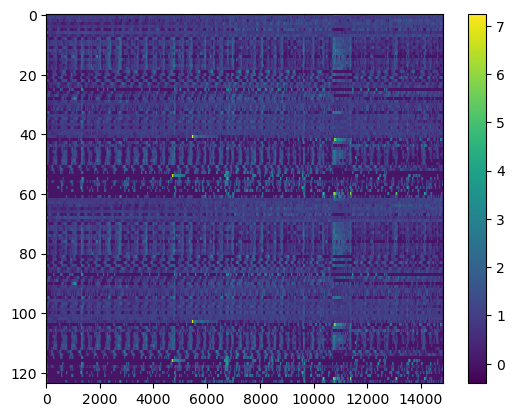

In [5]:
plt.imshow((observables[:].T),aspect="auto",interpolation="nearest")
plt.colorbar()

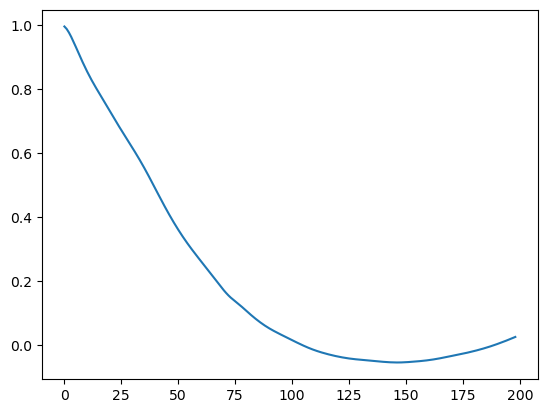

In [6]:
plt.plot(np.mean([[np.corrcoef(observables[k:,i], observables[:-k,i])[1,0] for k in range(1,200)] for i in range(50)],axis=0))

In [7]:
n_exp = 9
n_comp_list = [1,2,3,4,5,6,7,8]
models = []
unmixed_train_all = []
unmixed_test_all = []

for n_comp in n_comp_list:
    for exp in range(n_exp):
        trainer = imd_nd_smap.IMD_nD_smap(observables.shape[1], embed_dim=10, n_components=n_comp, subtract_corr=True, device="cuda")

        trainer.fit(observables_train, sample_len=170, library_len=700, 
                exclusion_rad=20, theta=5, tp=30, 
                epochs=500, num_batches=32,optimizer="Adagrad", learning_rate=0.01, tp_policy="range",loss_mask_size=3 if n_comp > 3 else None)
        models += [trainer.model]


        unmixed_train = trainer.predict(observables_train)
        unmixed_test = trainer.predict(observables_test)
        unmixed_train_all += [unmixed_train.copy()]
        unmixed_test_all += [unmixed_test.copy()]


NameError: name 'observables_train' is not defined

---

In [11]:
unmixed_train_all_concat = np.load("results/neural_unmixed_train_all_concat.npy")
unmixed_test_all_concat = np.load("results/neural_unmixed_test_all_concat.npy")

In [9]:
unmixed_train_all_concat = np.concatenate([np.transpose(i,(1,0,2)) for i in unmixed_train_all])
unmixed_test_all_concat = np.concatenate([np.transpose(i,(1,0,2)) for i in unmixed_test_all])

NameError: name 'unmixed_train_all' is not defined

In [53]:

ccm_unmixed_train = CCM.PairwiseCCM().compute(unmixed_train_all_concat,unmixed_train_all_concat,1500,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0)
ccm_unmixed_test = CCM.PairwiseCCM().compute(unmixed_test_all_concat,unmixed_test_all_concat,1500,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0)

ccm_unmixed_train[ccm_unmixed_train<0]=0
ccm_unmixed_test[ccm_unmixed_test<0]=0


In [54]:
unmixed_xmap_X_train = [np.mean([CCM.PairwiseCCM().compute(unmixed_train_all_concat[[i]],X[:observables_train.shape[0],].T[:,:,None],1200,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0) for exp in range(5)] ,axis=0) for i in range(unmixed_train_all_concat.shape[0])]
unmixed_xmap_X_train = np.array(unmixed_xmap_X_train).T[0]
unmixed_xmap_X_train[unmixed_xmap_X_train<0]=0

unmixed_xmap_X_test = [np.mean([CCM.PairwiseCCM().compute(unmixed_test_all_concat[[i]],X[observables_train.shape[0]:,].T[:,:,None],1200,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0) for exp in range(5)] ,axis=0) for i in range(unmixed_test_all_concat.shape[0])]
unmixed_xmap_X_test = np.array(unmixed_xmap_X_test).T[0]
unmixed_xmap_X_test[unmixed_xmap_X_test<0]=0



/home/iaroslav/miniconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/iaroslav/miniconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


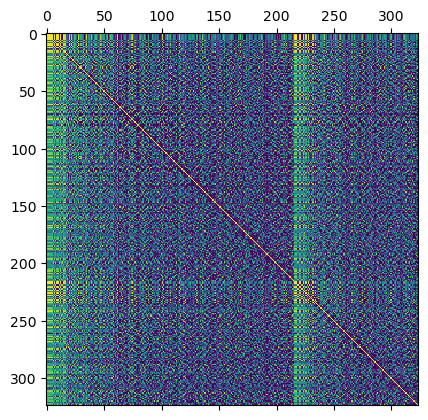

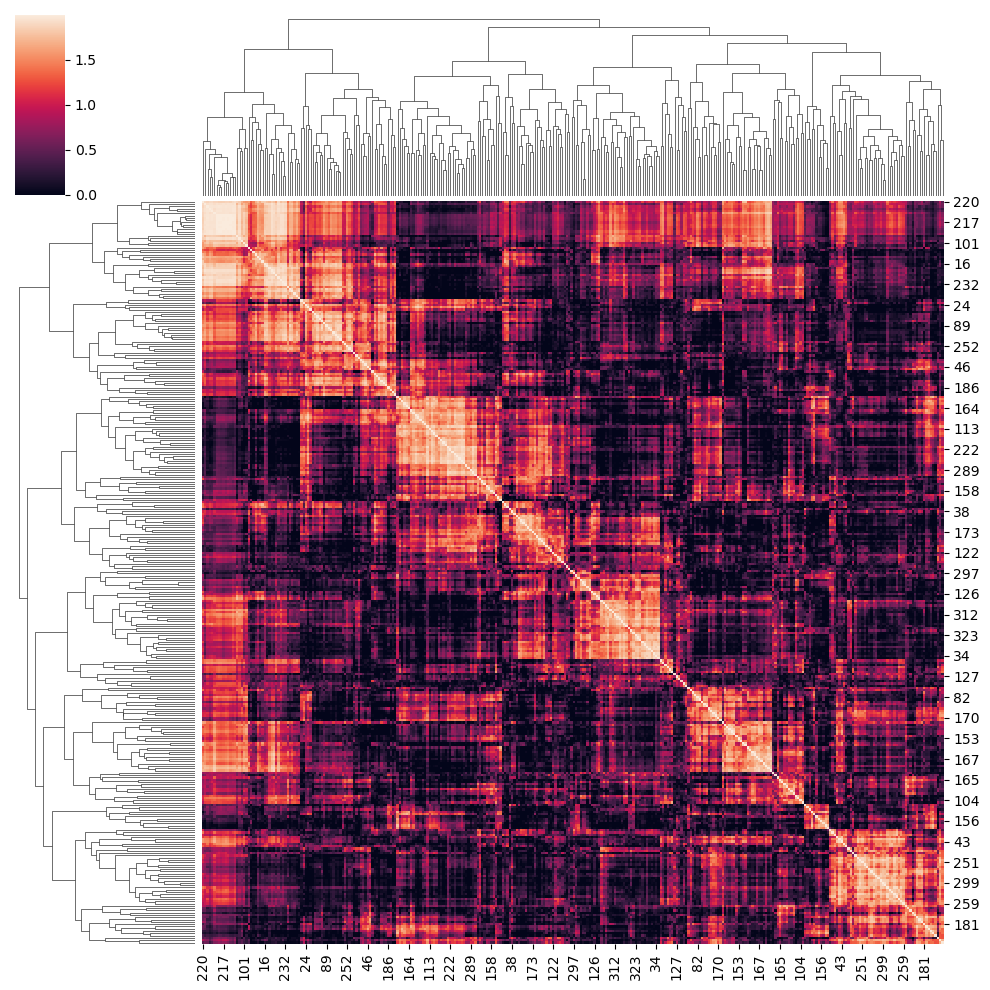

In [167]:


plt.matshow(ccm_unmixed_train,vmin=0,vmax=1)

# Generate the clustermap and get the linkage matrix for the columns
clustermap = sns.clustermap(ccm_unmixed_train + ccm_unmixed_train.T,method="average", col_cluster=True)
col_linkage = clustermap.dendrogram_col.linkage

n_clusters = 6
col_clusters = sch.cut_tree(col_linkage, n_clusters=n_clusters).flatten()

# Initialize a dictionary to store the barycenter variable for each cluster
barycenter_vars = []

# Iterate through each cluster
for cluster in range(n_clusters):
    # Get the indices of columns in this cluster
    cluster_indices = np.where(col_clusters == cluster)[0]
    
    # Extract the submatrix for this cluster
    cluster_matrix = ccm_unmixed_train[np.ix_(cluster_indices, cluster_indices)]
    
    # Calculate the average correlation for each variable in the cluster
    avg_correlations = cluster_matrix.mean(axis=1)
    
    # Find the index of the variable with the highest average correlation
    closest_variable_idx = cluster_indices[np.argmax(avg_correlations)]
    
    # Store the result
    barycenter_vars += [closest_variable_idx]
barycenter_vars = np.array(barycenter_vars)

ccm_unmixed_train_reduced = np.array([[ccm_unmixed_train[col_clusters==j][:,col_clusters==i].mean() for i in range(col_clusters.max()+1)] for j in range(col_clusters.max()+1)])

ccm_unmixed_train_reduced = CCM.PairwiseCCM().compute(unmixed_train_all_concat[barycenter_vars],unmixed_train_all_concat[barycenter_vars],1500,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0)
ccm_unmixed_train_reduced[ccm_unmixed_train_reduced<0]=0

unmixed_xmap_X_train_reduced = [np.mean([CCM.PairwiseCCM().compute(unmixed_train_all_concat[[i]],observables_train[:,:X.shape[1]].T[:,:,None],1200,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0) for exp in range(5)] ,axis=0) for i in barycenter_vars]
unmixed_xmap_X_train_reduced = np.array(unmixed_xmap_X_train_reduced).T[0]
unmixed_xmap_X_train_reduced[unmixed_xmap_X_train_reduced<0]=0

unmixed_xmap_X_test_reduced = [np.mean([CCM.PairwiseCCM().compute(unmixed_test_all_concat[[i]],observables_test[:,:X.shape[1]].T[:,:,None],1200,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0) for exp in range(5)] ,axis=0) for i in barycenter_vars]
unmixed_xmap_X_test_reduced = np.array(unmixed_xmap_X_test_reduced).T[0]
unmixed_xmap_X_test_reduced[unmixed_xmap_X_test_reduced<0]=0

X_xmap_unmixed_train_reduced = [np.mean([CCM.PairwiseCCM().compute(np.transpose(utils.get_td_embedding_np(observables_train[:,:62],3,5),(2,0,1))[[i]],unmixed_train_all_concat[barycenter_vars][:,:,[0]],1200,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0) for exp in range(5)] ,axis=0) for i in range(62)]
X_xmap_unmixed_train_reduced = np.array(X_xmap_unmixed_train_reduced).T[0]
X_xmap_unmixed_train_reduced[X_xmap_unmixed_train_reduced<0]=0

array([ 20,  11, 233, 288,  73, 167])

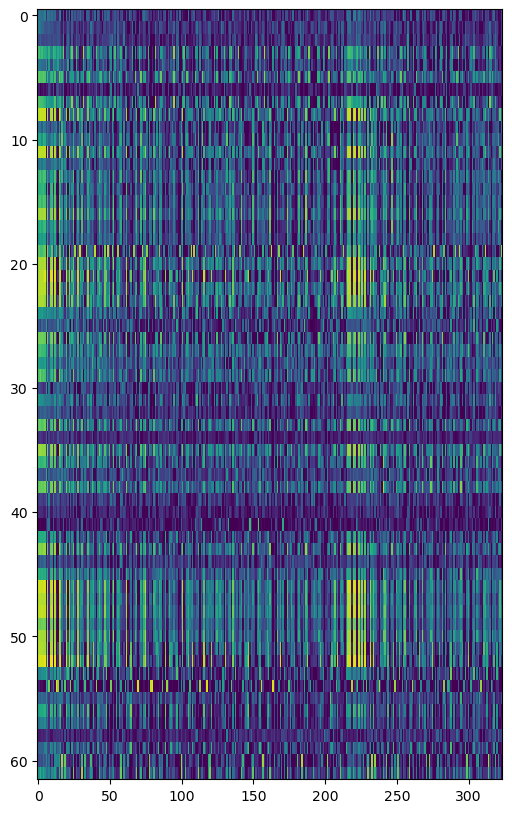

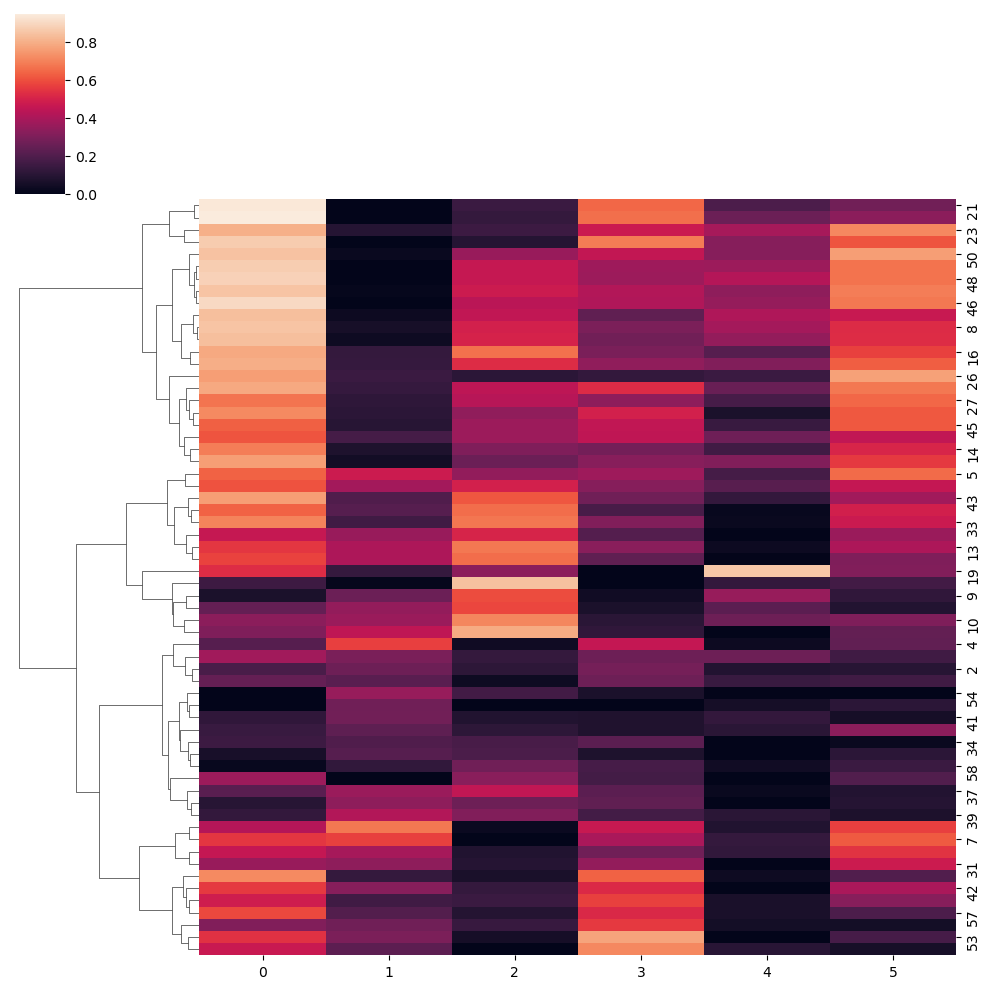

In [180]:
plt.figure(figsize=(6,10))

plt.imshow(unmixed_xmap_X_train,vmin=0,vmax=1,aspect="auto",interpolation="nearest")

sns.clustermap(unmixed_xmap_X_train[:,barycenter_vars], method="ward",col_cluster=False)

In [173]:

import umap
reducer = umap.UMAP(metric='precomputed', n_neighbors=25, min_dist=0.1, n_components=2, random_state=10)
X_umap = reducer.fit_transform(2-(ccm_unmixed_train+ccm_unmixed_train.T))

/home/iaroslav/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/iaroslav/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


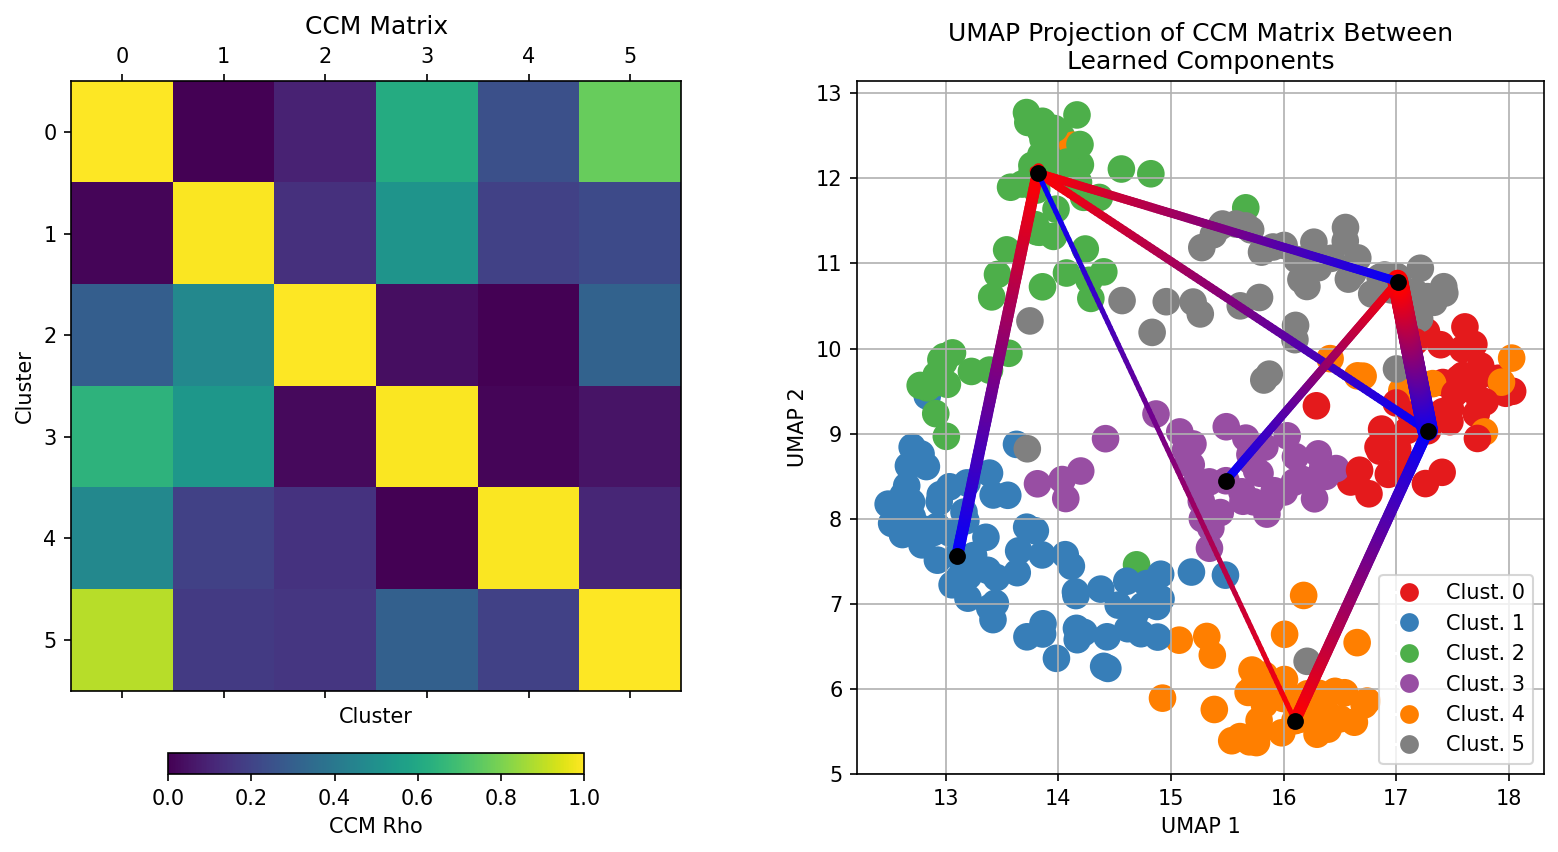

<Figure size 640x480 with 0 Axes>

In [174]:
colors = np.array([
    [0.894118, 0.101961, 0.109804],  # Red
    [0.215686, 0.494118, 0.721569],  # Blue
    [0.301961, 0.686275, 0.290196],  # Green
    [0.596078, 0.305882, 0.639216],  # Purple
    [1.000000, 0.498039, 0.000000],  # Orange
    [0.500000, 0.500000, 0.500000],
    [0.596078, 0.305882, 0.639216],  # Purple
    [1.000000, 0.498039, 1.000000],  # Orange
])
# Create subplots with 2 columns
fig, axes = plt.subplots(1, 2, figsize=(13, 6),dpi=150)  # (1 row, 2 columns)

# Plot the first subplot (matshow)
im = axes[0].matshow(ccm_unmixed_train_reduced, vmax=1, vmin=0)
axes[0].set_title("CCM Matrix")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Cluster")

# Add colorbar for the left subplot
cbar = plt.colorbar(im, ax=axes[0], fraction=0.03, pad=0.09,orientation="horizontal")
cbar.set_label("CCM Rho",)

# Plot the second subplot (scatter and arrows)
scatter_ax = axes[1]
scatter = scatter_ax.scatter(
    X_umap[:, 0], X_umap[:, 1],
    c=[colors[i] for i in col_clusters],
    s=150
)
scatter_ax.set_title("UMAP Projection of CCM Matrix Between\nLearned Components")

# Add a custom legend
cluster_labels = ["Clust. 0", "Clust. 1", "Clust. 2", "Clust. 3", "Clust. 4", "Clust. 5"]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=label)
           for i, label in enumerate(cluster_labels)]
scatter_ax.legend(handles=handles)
scatter_ax.set_xlabel("UMAP 1")
scatter_ax.set_ylabel("UMAP 2")

# Call the custom function for arrows
plot_pairwise_arrows_with_direction_gradient(
    scatter_ax,
    (ccm_unmixed_train_reduced.T - ccm_unmixed_train_reduced) > 0.1,
    ccm_unmixed_train_reduced.T,
    X_umap[barycenter_vars]
)

# Adjust layout for better appearance
plt.tight_layout()
# Show the plots
plt.show()


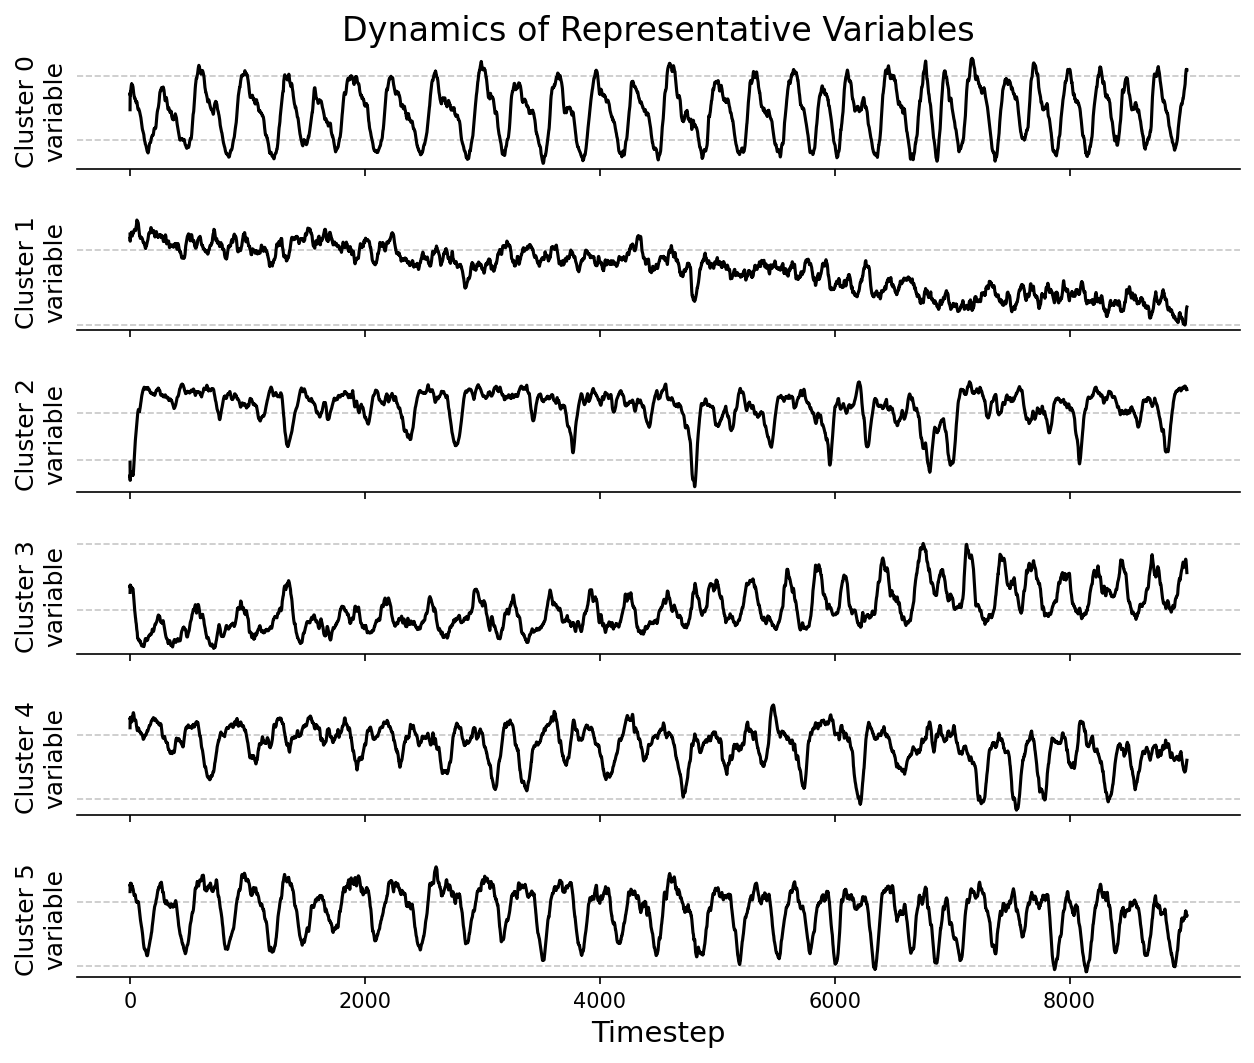

In [210]:
import matplotlib.pyplot as plt

# Assuming `unmixed_train_all_concat` is your dataset and `barycenter_vars` contains your variable names
fig, axes = plt.subplots(len(barycenter_vars), 1, figsize=(10, 8), dpi=150,sharex=True)

for i, var in enumerate(barycenter_vars):
    axes[i].plot(unmixed_train_all_concat[var][:, 0], color="black")
    
    # Add a label on the left indicating the variable
    axes[i].set_ylabel(f"Cluster {i}\nvariable", fontsize=12, labelpad=5)
    axes[i].yaxis.set_label_position("left")
    axes[i].tick_params(axis="y", which="both", left=False, labelleft=False)  # Remove tick marks on y-axis

    # Remove borders
    axes[i].spines["top"].set_visible(False)
    axes[i].spines["right"].set_visible(False)
    axes[i].spines["left"].set_visible(False)
    
    # Add a grid for clarity
    axes[i].grid(axis="y", linestyle="--", alpha=0.7)

# Label the shared x-axis
axes[-1].set_xlabel("Timestep", fontsize=14)

axes[0].set_title("Dynamics of Representative Variables",fontsize=16)
# Adjust spacing for compactness
plt.subplots_adjust(hspace=0.4)  # Space between subplots
plt.show()


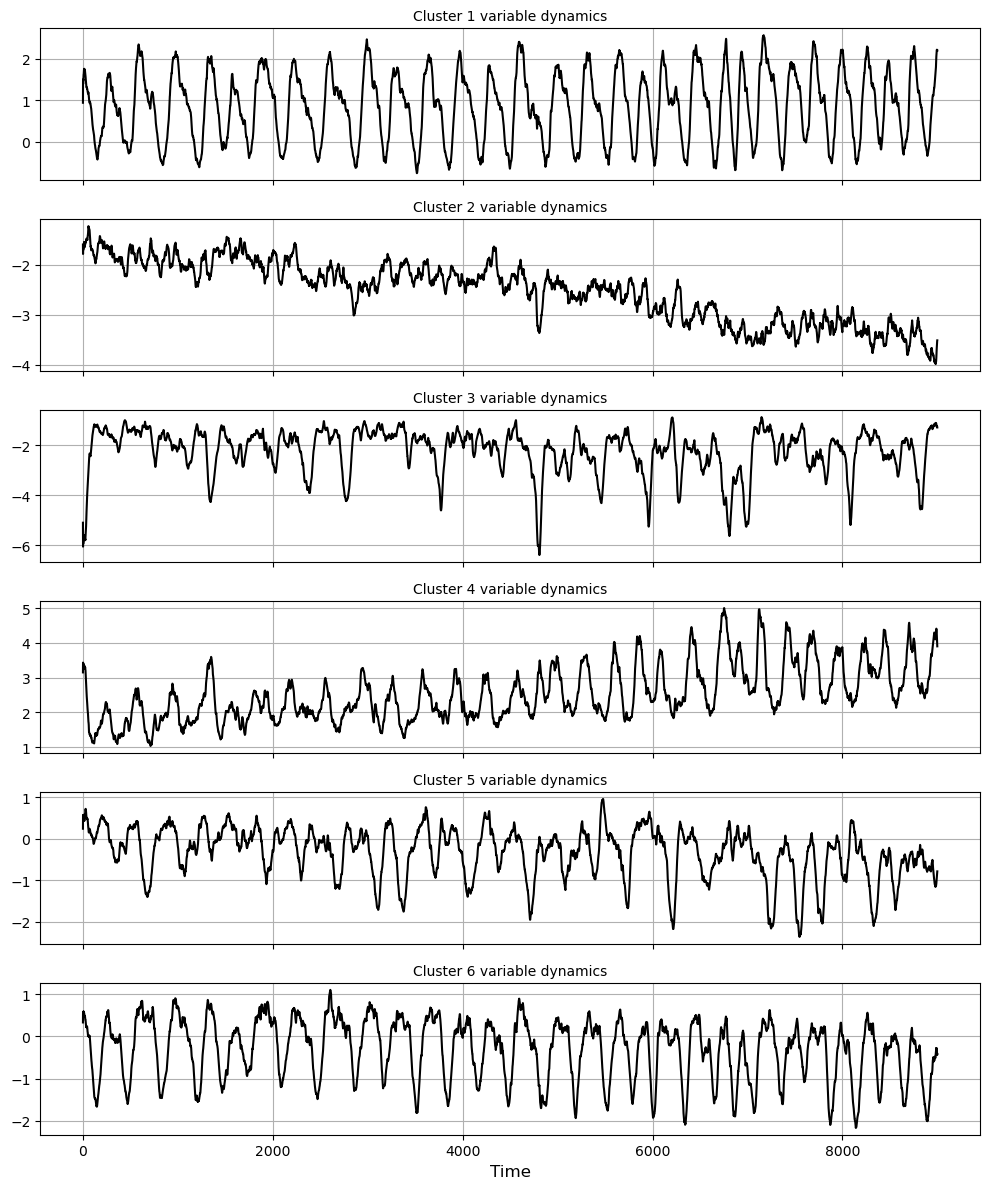

In [185]:
import matplotlib.pyplot as plt

# Assuming `unmixed_train_all_concat` is your dataset and `barycenter_vars` contains your variable names
fig, axes = plt.subplots(len(barycenter_vars), 1, figsize=(10, 12), sharex=True)

for i, var in enumerate(barycenter_vars):
    axes[i].plot(unmixed_train_all_concat[var][:, 0], color="black")
    axes[i].set_title(f"Cluster {i + 1} variable dynamics", fontsize=10)
    axes[i].grid(True)

# Adding labels for shared x-axis
axes[-1].set_xlabel("Time", fontsize=12)

# Adjust spacing between subplots for better readability
plt.tight_layout()
plt.show()


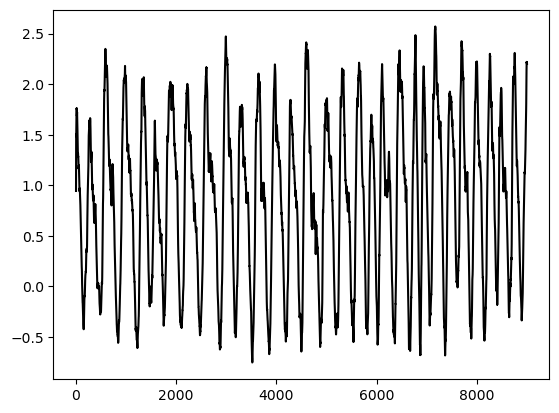

In [181]:

plt.plot(unmixed_train_all_concat[barycenter_vars[0]][:,0],color="black")

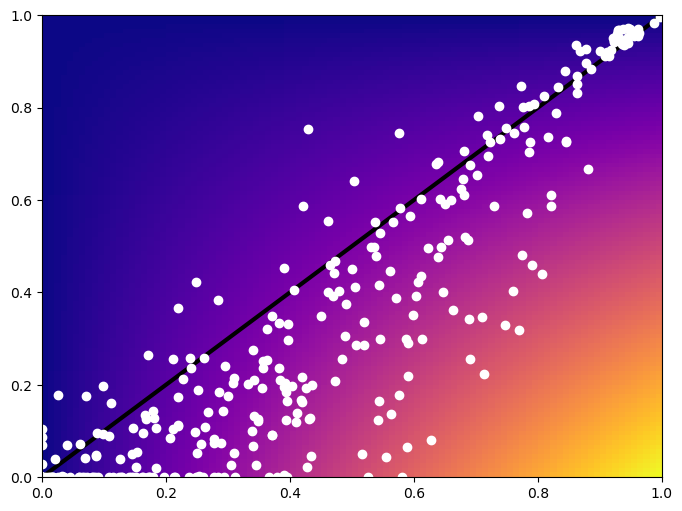

In [26]:


bx = np.linspace(0, 1, 100)
by = np.linspace(1, 0, 100)
gradient = np.outer(by,bx)  

fig, ax = plt.subplots(figsize=(8, 6))

ax.imshow(gradient, extent=[0, 1, 0, 1], origin='lower', aspect='auto', cmap='plasma')

ax.plot([0, 1], [0, 1], color="black", lw=3)
ax.scatter(ccm_unmixed_train[:,barycenter_vars[0]],ccm_unmixed_train[barycenter_vars[0]],c="white",zorder=2)


In [108]:
density = np.sort(ccm_unmixed_train+ccm_unmixed_train.T,axis=1)[:,-20:-1].mean(axis=1)/2

In [129]:
density.shape

(324,)

Text(0, 0.5, 'UMAP 2')

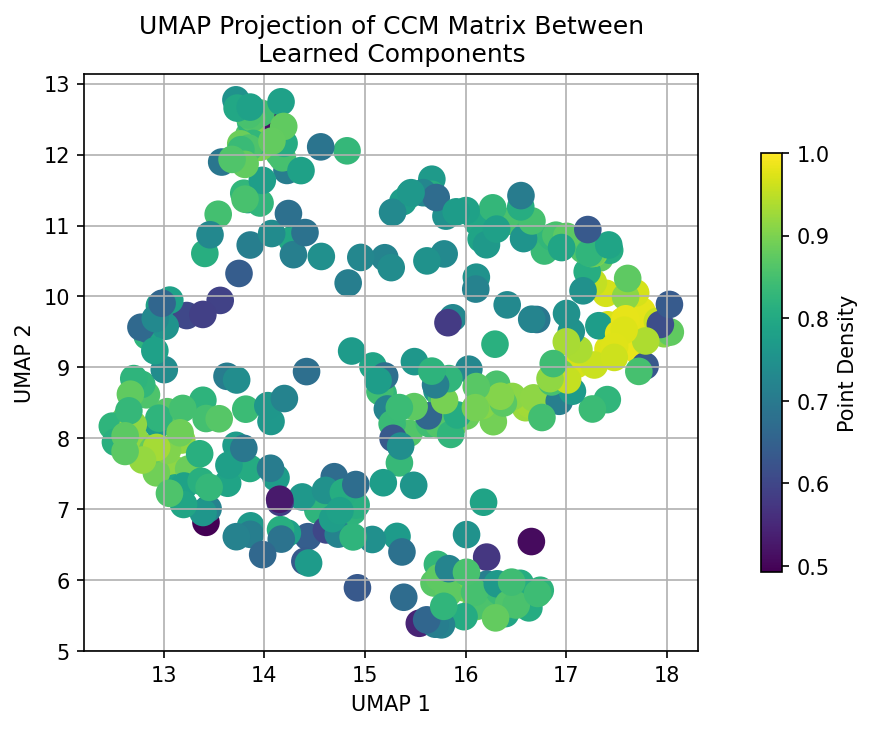

In [175]:
plt.figure(figsize=(6,5),dpi=150)
plt.grid()
plt.scatter(X_umap[:, 0], X_umap[:, 1],c=density, cmap='viridis', s=150,vmax=1)
plt.colorbar(fraction=0.03, pad=0.09,label="Point Density")
plt.title("UMAP Projection of CCM Matrix Between\nLearned Components")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

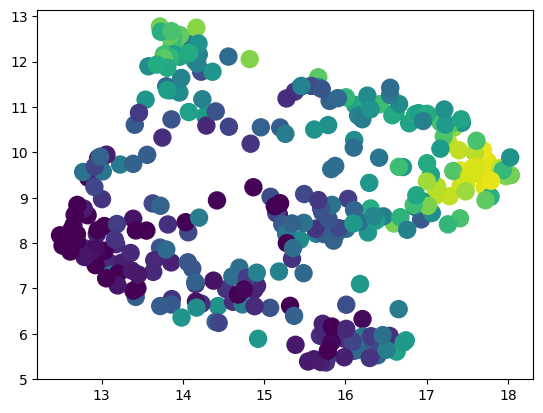

In [61]:

plt.scatter(X_umap[:, 0], X_umap[:, 1],c=(CCM.PairwiseCCM().compute(unmixed_train_all_concat,
PCA(10).fit_transform(observables_train[:,:62]).T[:,:,None],1500,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0))[0], cmap='viridis', s=150,vmin=0,vmax=1)


array([[ 2.51861385,  1.60531658,  1.07517238, ...,  0.75648157,
         0.69490623,  0.78941182],
       [ 8.74675024,  5.56213467,  4.65204836, ...,  1.73351223,
         1.03447726,  0.31008146],
       [ 7.45812041,  4.70519462,  3.97534457, ...,  1.72418592,
         0.87811244,  0.4508862 ],
       ...,
       [-1.91330072,  3.55646532, -1.59783434, ..., -1.27389605,
        -0.53398508,  0.16549548],
       [-1.89728398,  3.49789134, -1.54978891, ..., -1.21341639,
        -0.61880188,  0.14647709],
       [-1.86311274,  3.45581896, -1.5392113 , ..., -1.14666055,
        -0.67281684,  0.10751563]])

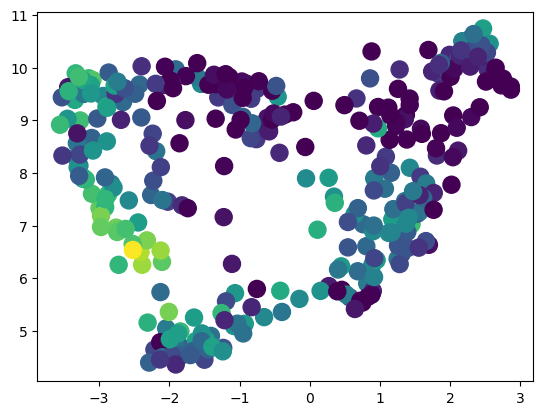

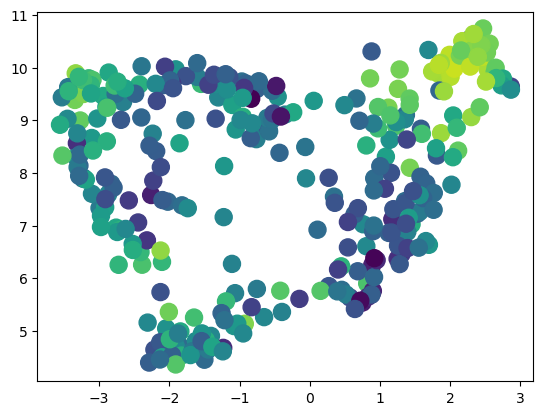

In [30]:


# Plot the results
#plt.scatter(X_umap[:, 0], X_umap[:, 1],c=np.repeat([1,2,3,4,5,6,7,8],np.array([1,2,3,4,5,6,7,8])*6), cmap='viridis', s=50)

plt.scatter(X_umap[:, 0], X_umap[:, 1],c=ccm_unmixed_train[-5], cmap='viridis', s=150,vmax=1,vmin=0)
plt.show()
plt.scatter(X_umap[:, 0], X_umap[:, 1],c=unmixed_xmap_X_test[19], cmap='viridis', s=150,vmax=1,vmin=0)

In [31]:

plt.scatter(X_umap[:, 0], X_umap[:, 1],c=np.repeat(n_comp_list,np.array(n_comp_list)*9), cmap='plasma', s=30 * np.repeat(n_comp_list,np.array(n_comp_list)*9)[::-1])

NameError: name 'n_comp_list' is not defined

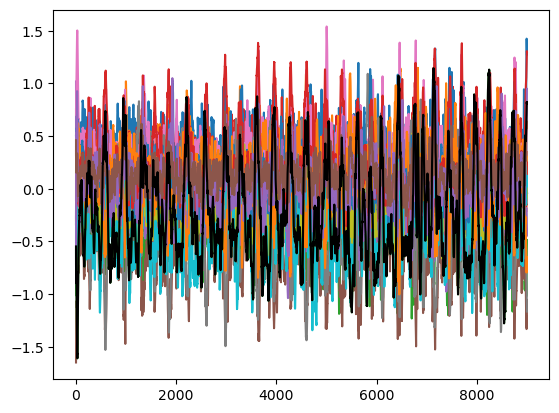

In [154]:
plt.plot(unmixed_train_all_concat[col_clusters==5][:,:,0].T)
plt.plot(unmixed_train_all_concat[barycenter_vars[5]][:,0],color="black")

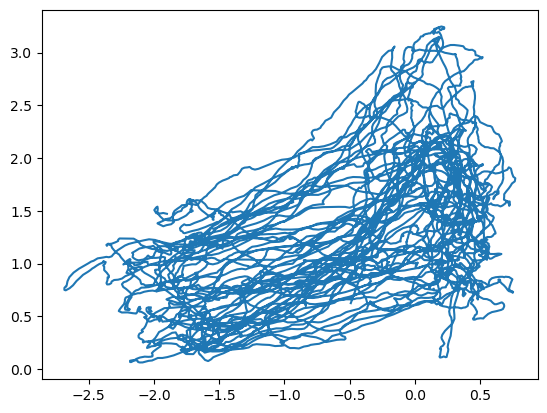

In [519]:
plt.plot(unmixed_train_all_concat[barycenter_vars[0]][:,0],unmixed_train_all_concat[barycenter_vars[4]][:,0],)

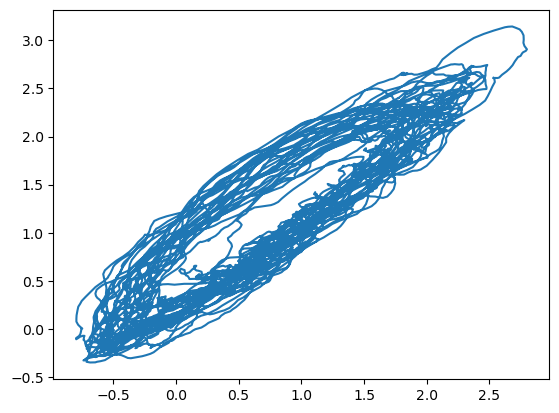

In [104]:
plt.plot(unmixed_train_all_concat[barycenter_vars[0]][:,3],unmixed_train_all_concat[barycenter_vars[0]][:,4],)

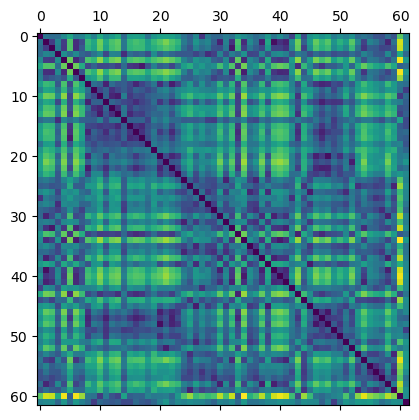

In [105]:
from sklearn.metrics import pairwise_distances
plt.matshow(pairwise_distances(unmixed_xmap_X_test_reduced))

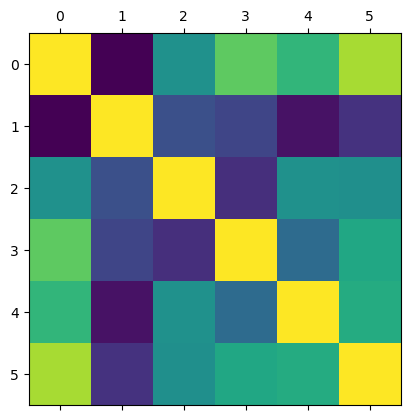

In [115]:
plt.matshow(np.corrcoef(unmixed_xmap_X_train_reduced.T))

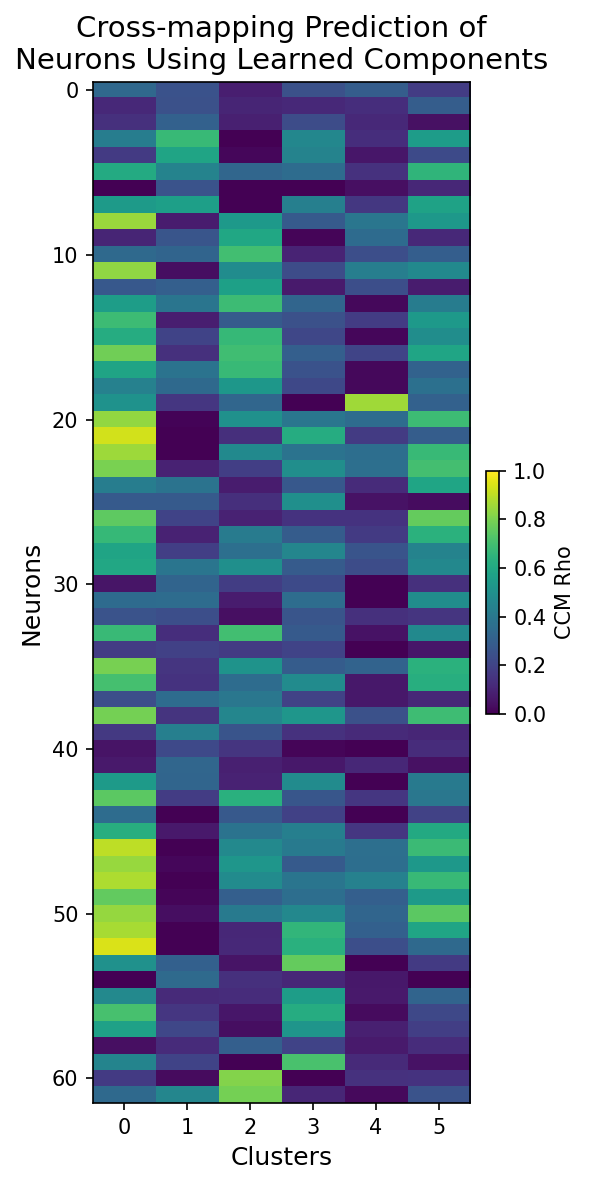

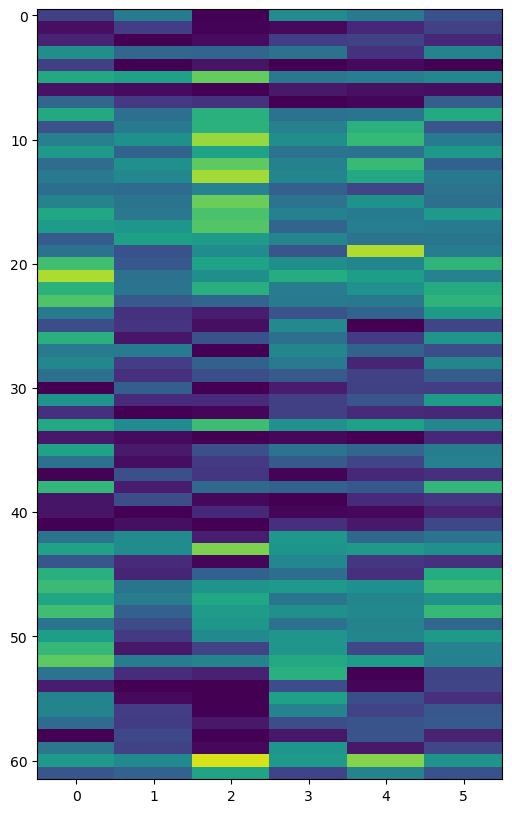

In [225]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 8), dpi=150)

# Display the matrix
plt.imshow(
    unmixed_xmap_X_train_reduced,
    vmin=0,
    vmax=1,
    aspect="auto",
    interpolation="nearest",
    cmap="viridis",  # Optional: Use a perceptually uniform colormap
)
# Add a colorbar with appropriate padding and label
plt.colorbar(fraction=0.03, pad=0.04, label="CCM Rho")

# Add axis labels and title
plt.ylabel("Neurons", fontsize=12)
plt.xlabel("Clusters", fontsize=12)
plt.title("Cross-mapping Prediction of\nNeurons Using Learned Components", fontsize=14)

# Adjust layout for better readability
plt.tight_layout()

plt.show()

plt.figure(figsize=(6,10))

plt.imshow(unmixed_xmap_X_test_reduced,vmin=0,vmax=1,aspect="auto",interpolation="nearest")


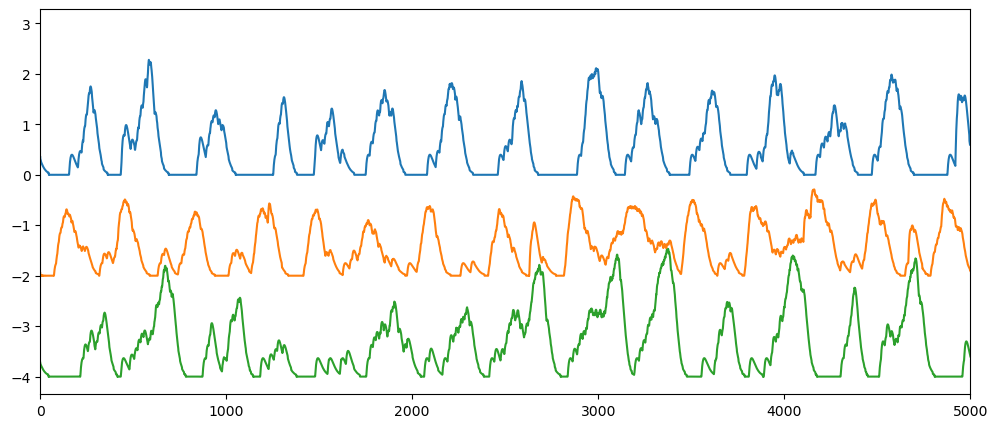

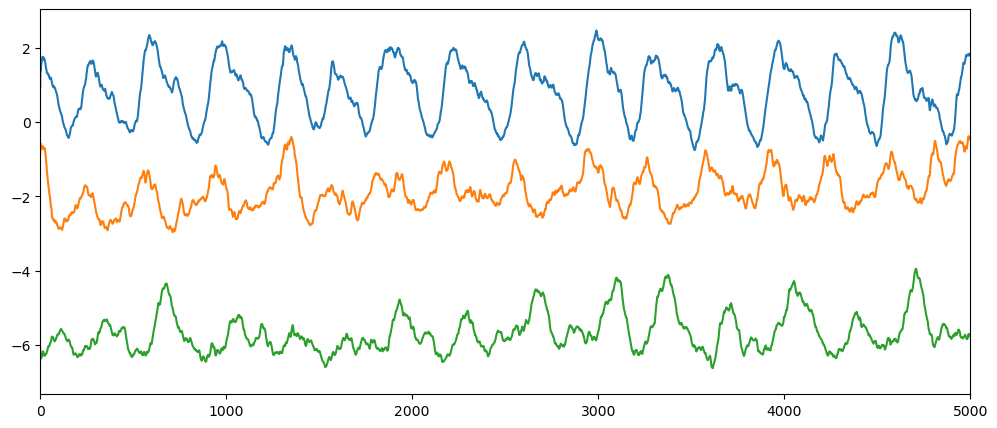

In [166]:
plt.figure(figsize=(12,5))
plt.plot(observables[:,21])
plt.plot(observables[:,5]-2)
plt.plot(observables[:,19]-4)
plt.xlim(0,5000)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(unmixed_train_all_concat[barycenter_vars[0]][:,0])
plt.plot(unmixed_train_all_concat[barycenter_vars[4]][:,0]-4)
plt.plot(unmixed_train_all_concat[barycenter_vars[5]][:,1]-6)
plt.xlim(0,5000)
plt.show()

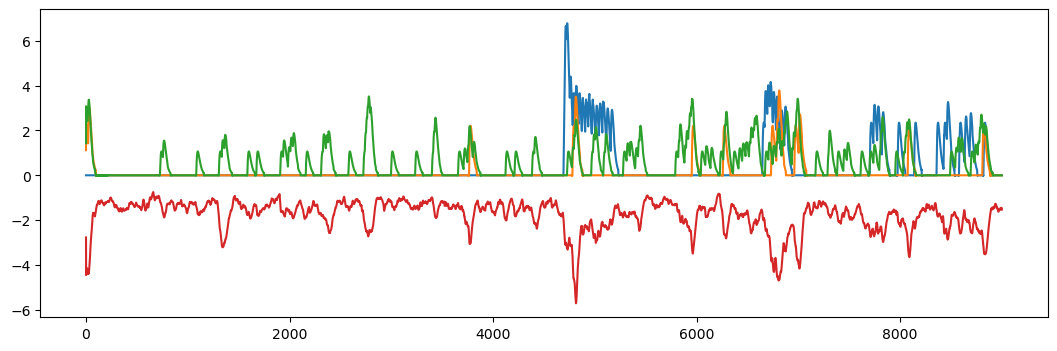

In [667]:
plt.figure(figsize=(13,4))
plt.plot(observables_train[:,54])
plt.plot(observables_train[:,60])
plt.plot(observables_train[:,61])
plt.plot(unmixed_train_all_concat[barycenter_vars[3]][:,0])